# ML T-Generation Занятие 6: Обучение без учителя.
## Кластеризация: K-Means, DBSCAN, Аггломеративная.
## Уменьшение размерности: SVD, PCA, tSNE.

Автор: Гаркавый Андрей (andrewgarkavyy@gmail.com)


## 0. План

1. Обучение без учителя. Кластеризация.

2. K-Means.

3. Метрика качества кластеризации.

4. DBSCAN.

5. Агломеративная кластеризация.

6. Уменьшение размерности и визуализация.

7. SVD.

8. PCA

9. t-SNE

10. Применение уменьшения размерности для классификации

## 1. Обучение без учителя

Ранее мы рассматривали в основном только задачи, где у части данных (тренировочной) была размечена целевая функция (таргет), а для другой части данных (тестовой) таргета нет, и мы хотели его восстановить. Такие задачи (классификация, регрессия, ранжирование), как вы помните, называются **обучением с учителем** (supervised learning).

Давайте посмотрим теперь на задачи, в которых таргета не дано - но все же что-то сопоставить каждому элементу надо. Такие задачи называются **обучением без учителя** (unsupervised learning).

Примеры таких задач:
* кластеризация
* уменьшение размерности
* визуализация
* вложение в пространство

Одна из особенностей обучения без учителя - нам не нужны тренировочная и тестовая выборка. Нет таргета - нет проблем с переобучением.


### Кластеризация
Эту задачу вы знаете: она состоит в разделении точек в пространстве на кластеры близко расположенных.

In [1]:
# стандартные импорты
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Кластеры сложной структуры')

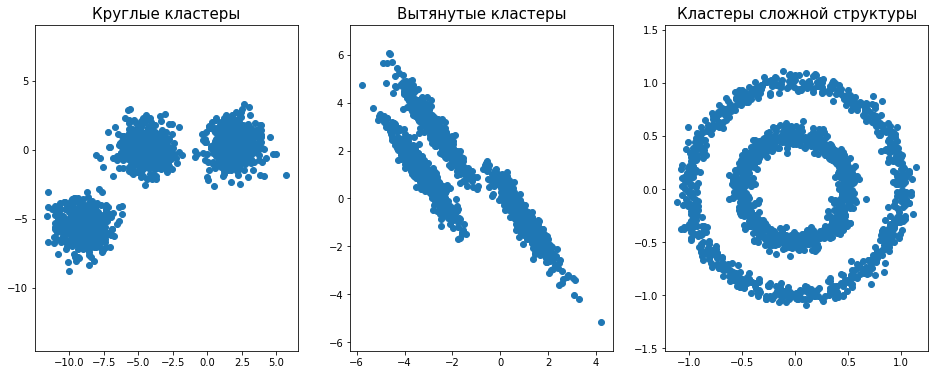

In [2]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

plt.figure(figsize=(16, 6))

X, y = make_blobs(n_samples=1500, centers=3, random_state=170)
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], edgecolors='face')
plt.axis('equal') # чтобы рисунок был не растянут
plt.title(u"Круглые кластеры", fontsize=15)

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]] # матрица преобразования
X_long = np.dot(X, transformation) # умножим на нее, чтобы растянуть кучки

plt.subplot(132)
plt.scatter(X_long[:, 0], X_long[:, 1], edgecolors='face')
plt.axis('equal') # чтобы рисунок был не растянут
plt.title(u"Вытянутые кластеры", fontsize=15)

X_circles, y = make_circles(n_samples=1500, factor=0.5, noise=0.05)
plt.subplot(133)
plt.scatter(X_circles[:, 0], X_circles[:, 1], edgecolors='face')
plt.axis('equal') # чтобы рисунок был не растянут
plt.title(u"Кластеры сложной структуры", fontsize=15)

In [3]:
def apply_clusterization_algorithm(model_1, model_2, model_3):
    plt.figure(figsize=(16, 6))

    plt.subplot(131)
    y_pred = model_1.fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolors='face')
    plt.axis('equal') # чтобы рисунок был не растянут
    plt.title(u"Круглые кластеры", fontsize=15)

    plt.subplot(132)
    y_pred = model_2.fit_predict(X_long)
    plt.scatter(X_long[:, 0], X_long[:, 1], c=y_pred, edgecolors='face')
    plt.axis('equal') # чтобы рисунок был не растянут
    plt.title(u"Вытянутые кластеры", fontsize=15)

    plt.subplot(133)
    y_pred = model_3.fit_predict(X_circles)
    plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_pred, edgecolors='face')
    plt.axis('equal') # чтобы рисунок был не растянут
    plt.title(u"Кластеры сложной структуры", fontsize=15)

## 2. Алгоритм K-Means.
<a href='https://www.naftaliharris.com/blog/visualizing-k-means-clustering/'> Визуализация</a>.

Нужно в начале выбрать K центров кластеров (K - константа, которую надо самому выбрать).

Дале итеративно выполняются 2 шага, пока обновления не перестанут происходить:
* Обновить кластеры, приписав каждой точке кластер самого близкого к ней центра
* Обновить центр каждого кластера как центр масс его точек

**Плюсы**:
* простой и понятный

**Минусы**:
* нужно знать K
* слишком простая модель, кластер = выпуклая околокруглая штука, так как это по сути диаграмма Вороного (если вы знаете, что это такое)
* если плохо выбрать начальные центры, может сойтись к плохому результату

Поэтому обычно K-Means запускают несколько раз и выбирают лучший результат.

Давайте применим K-Means для K=5.

In [4]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
y_pred = model.fit_predict(X)
y_pred

array([4, 4, 3, ..., 2, 2, 2], dtype=int32)

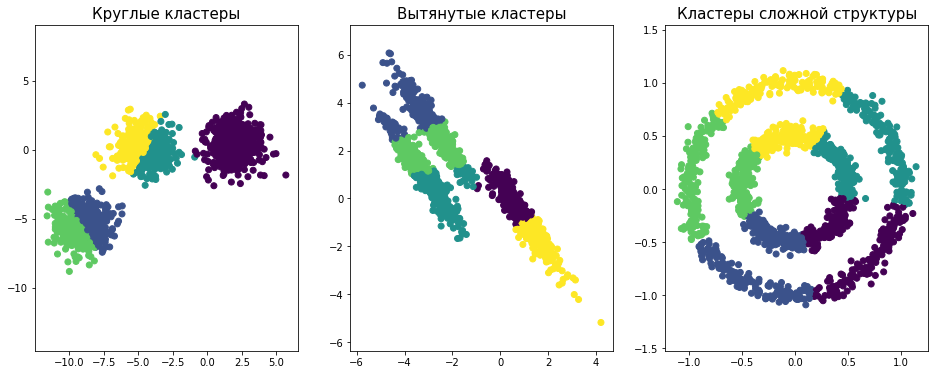

In [5]:
# нарисуем результаты для 3 множеств выше
apply_clusterization_algorithm(KMeans(n_clusters=5),
                               KMeans(n_clusters=5),
                               KMeans(n_clusters=5))

**Дополнительное задание 1:** всегда ли сойдется алгоритм K-Means?

## 3. Метрика качества кластеризации

Как и для задач обучения с учителем, хочется уметь понимать, хорошо ли мы решили задачу - нужно научиться измерять качество кластеризации. Так, например, даже не зная число кластеров, можно перебрать K в K-Means и выбрать гиперпараметр с лучшим качеством.

Одним из примеров метрики может быть метрика **силуэт**.

Для одного элемента $x$ она считается так:

$$S(x) = \frac{b(x) - a(x)}{\max{(a(x), b(x))}}$$

$a(x) =$ среднее расстояние от x до точек внутри того же кластера.

$b(x) = $ среднее расстояние от x до точек внутри ближайшего кластера.

Сама метрика равна среднему значению S(x) от каждого элемента.

In [6]:
from sklearn.metrics import silhouette_score
model = KMeans(n_clusters=5)
y_pred = model.fit_predict(X)
print(silhouette_score(X, y_pred))

0.4411389512013541


Видно, что $-1 \leq S(x) \leq 1$, причем чем больше $b(x)$ относительно $a(x)$, тем метрика ближе к $1$. Чем метрика больше - тем лучше кластеризация.

**Обязательное задание 1**: переберите $K$ в K-Means и нарисуйте график зависимости метрики силуэт от $K$ для круглых кластеров. Для какого $K$ получается лучший результат? Попробуйте то же самое сделать для длинных и сложных данных (X_long и X_circles).

In [7]:
def find_best(data, le=2, re=11):
    le = 2
    re = 11
    scores = []
    for k in range(le, re):
        model = KMeans(n_clusters=k)
        y_pred = model.fit_predict(data)
        scores.append(silhouette_score(data, y_pred))
    print(np.max(scores))
    print(le + np.argmax(scores))

In [8]:
find_best(X)

0.7333423486262539
3


In [9]:
find_best(X_long)

0.6244801537550524
2


In [10]:
find_best(X_circles, 5, 20)

0.4165109288229664
10


**Обязательное задание 2:** чему будем равна метрика, если $K = |X|$? Встроенный алгоритм вам не позволит это сделать, интересен теоретический ответ.

**Ответ:** $a(x) = 0$. Тогда получится $\frac{b(x)}{b(x)} = 1$. То есть лучшее возможное качество

**Обязательное задание 3:** для лучших $K$ нарисуйте рисунок:

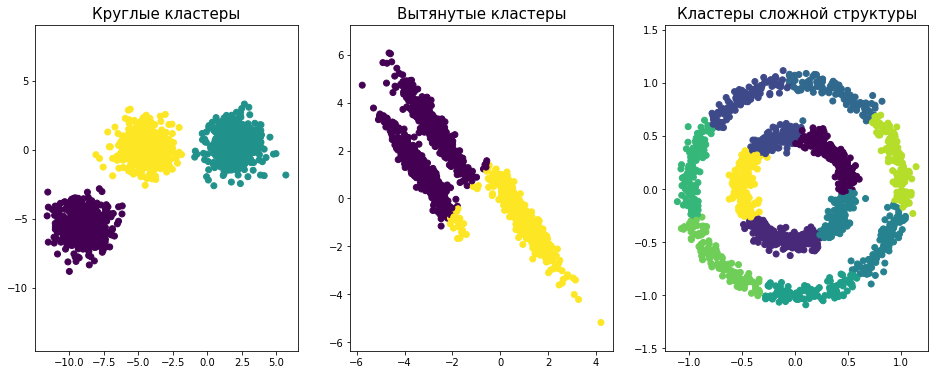

In [11]:
# нарисуем результаты для 3 множеств выше
apply_clusterization_algorithm(KMeans(n_clusters=3),
                               KMeans(n_clusters=2),
                               KMeans(n_clusters=10))

## 4. DBSCAN.
<a href='https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/'> Визуализация</a>.

DBSCAN строит столько кластеров, сколько получится, причем многие вершины могут не войти ни в один кластер, они называются **выбросами**.

DBSCAN опирается на два гиперпараметра:
* eps - означает расстояние, на котором две вершины считаются соседями
* min_samples - означает сколько нужно соседей из кластера, чтобы считать вершину коренной вершиной кластера

Сам алгоритм состоит из таких шагов:
* Выбрать соседей для каждой вершины на расстоянии до eps
* Найти компоненты связности коренных вершин - добавляем вершину в компоненту коренных, если у нее хотя бы min_samples соседей лежат в этой компоненте
* Добавить оставшиеся вершины в самый популярный кластер соседей, если есть соседи
* Оставшиеся вершины - это выбросы

**Плюсы**:
* сам подберет число кластеров
* опирается на плотность точек, кластеры могут быть вытянутыми и даже невыпуклыми

**Минусы**:
* нужно подбирать два других параметра
* алгоритм считает, что в разных частях данных плотности должны быть примерно одинаковыми

In [12]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1.0, min_samples=3)
y_pred = model.fit_predict(X)
silhouette_score(X, y_pred)

0.5857340321247474

**Обязательное задание 4**: для каждых из этих 3 данных найдите перебором лучшие гиперпараметры для DBSCAN.

In [13]:
def find_best(data, le=0.2, re=1, le2=2, re2=10):
    scores = {}
    for eps in np.linspace(le, re, 10):
        for n in range(le2, re2):
            model = DBSCAN(eps=eps, min_samples=n)
            y_pred = model.fit_predict(data)
            scores[(eps, n)] = silhouette_score(data, y_pred)
    print(max(scores.items(), key=lambda x : x[1]))

In [14]:
find_best(X)

((1.0, 8), 0.7307911535902176)


In [15]:
find_best(X_long)

((0.37777777777777777, 4), 0.6204338217917164)


In [16]:
find_best(X_circles, 0.1, 0.2, 1, 6)

((0.11111111111111112, 1), 0.11366501923327292)


**Обязательное задание 5:** для лучших гиперпараметров нарисуйте рисунок:

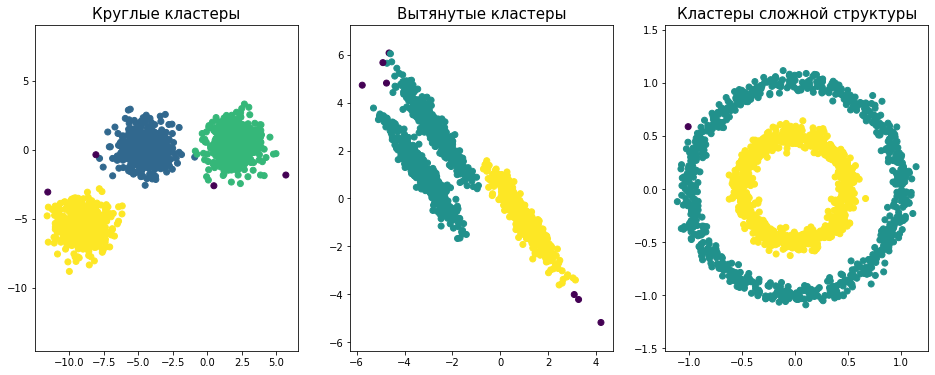

In [17]:
apply_clusterization_algorithm(DBSCAN(eps=1.0, min_samples=8),
                               DBSCAN(eps=0.37, min_samples=4),
                               DBSCAN(eps=0.1, min_samples=5)) # подобрано руками

## 5. Агломеративная кластеризация

Интуиция у алгоритма очень простая:

1) Начинаем с того, что высыпаем на каждую точку свой кластер

2) Сортируем попарные расстояния между центрами кластеров по возрастанию

3) Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера

4) Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

---

Чтобы найти пару ближайших кластеров берут не только расстояние между центрами, бывают и такие метрики:

1) Single linkage — минимум попарных расстояний между точками из двух кластеров

2) Complete linkage — максимум попарных расстояний между точками из двух кластеров

3) Average linkage — среднее попарных расстояний между точками из двух кластеров

4) Centroid linkage — расстояние между центроидами двух кластеров

По итогам выполнения такого алгоритма строится **дерево** склеивания кластеров. Глядя на него можно определить, на каком этапе оптимальнее всего остановить алгоритм.

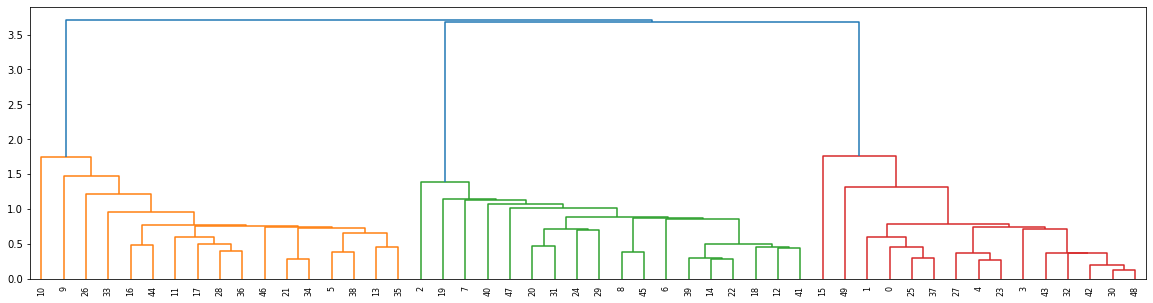

In [18]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(X[:50]) # pdist считает попарные расстояние расстояния

Z = hierarchy.linkage(distance_mat, 'single') # linkage — как считать расстояние между кластерами
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z, color_threshold=2.0) 

У этого алгоритма тое есть встроенная моделька, которая принимает n_clusters и прекращает процесс в тот момент, когда столько кластеров и осталось.

In [19]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5, linkage='single')
y_pred = model.fit_predict(X)
silhouette_score(X, y_pred)

0.5954324856788834

**Обязательное задание 6**: для каждых из этих 3 данных найдите перебором лучшие гиперпараметры для аглоемративной кластеризации.

In [25]:
from sklearn.model_selection import GridSearchCV
model = AgglomerativeClustering()
grid = {'linkage' : ['ward', 'complete', 'average', 'single'], 'n_clisters' : np.arange(1, 6)}
clf = GridSearchCV(model, grid)
scores = {}
def find_best(data):
    for link in ['ward', 'complete', 'average', 'single']:
        for n in np.arange(2, 7):
            y_pred = AgglomerativeClustering(n_clusters=n, linkage=link).fit_predict(data)
            scores[(n, link)] = silhouette_score(data, y_pred)
    print(max(scores.items(), key = lambda x: x[1]))

In [26]:
find_best(X)

((3, 'ward'), 0.7333423486262539)


In [27]:
find_best(X_long)

((2, 'average'), 0.6272259990066807)


In [28]:
find_best(X_circles)

((3, 'average'), 0.3691977517988882)


**Обязательное задание 7**: для лучших гиперпараметров нарисуйте рисунок:

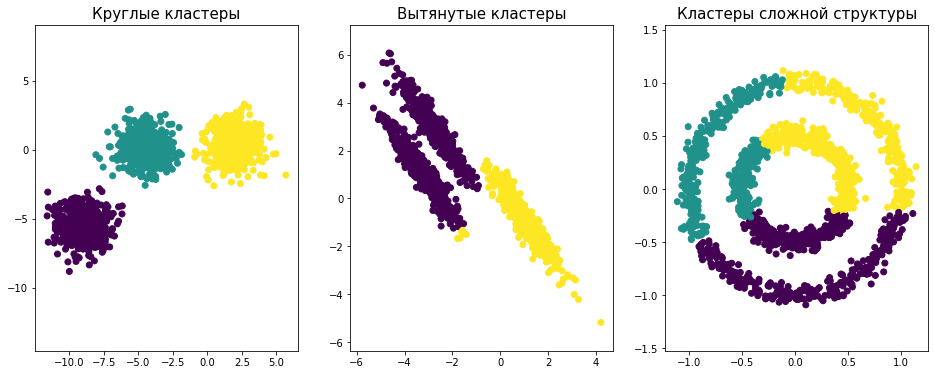

In [29]:
apply_clusterization_algorithm(AgglomerativeClustering(n_clusters=3, linkage='ward'),
                               AgglomerativeClustering(n_clusters=2, linkage='average'),
                               AgglomerativeClustering(n_clusters=3, linkage='average'))

## 6. Уменьшение размерности и визуализации

Обе эти задачи состоят в **сжатии выборки**: нужно перевести точки из N-мерного пространства в M-мерное пространство, где M < N, причем так, чтобы близкие точки остались близкими. То есть хочется значительно уменьшить число признаков, не сильно потеряв (или даже улучшив) их качество.

Для примеров мы будем чаще всего переводить в 2-мерное пространство - это заодно и хороший способ **визуализировать** датасет.

Давайте, например, рассмотрим известный датасет с цифрами.

In [30]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

Каждое изображение представляет из себя квадратик 8x8, в каждой клетке которого написано число от 0 до 15 - насколько клетка черная. Вот, например, ноль:

In [31]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [32]:
y[0]

0

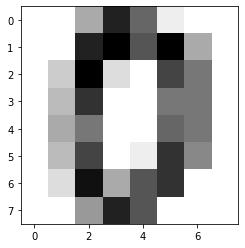

In [33]:
plt.imshow(X[0].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

Можем посмотреть на разные цифры, например на пятерки:

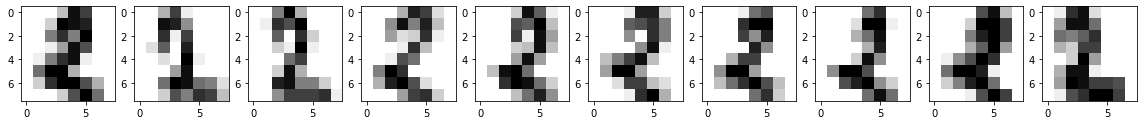

In [38]:
DIGIT = 2
NUMBER_DIGITS = 10

plt.figure(figsize=(20, 12))
digits = X[(y == DIGIT)][:NUMBER_DIGITS]
for i in range(len(digits)):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(digits[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

Рассмотрим каждое изображение как на вектор в 64-мерном пространстве (64 признака). 

Тогда интересно уменьшить размерность этих векторов до 2.

Помимо визуализации уменьшение размерности очень часто используют для **отбора признаков**. Вместо 64 малозначащих признаков мы хотим оставить 2, в которых лежит как можно больше информации. Заметьте, что это слабый способ отбора признаков: мы никак не используем значение таргета.

## 7. SVD - используем матрицы

В этом методе уменьшения размерности применяется SVD-разложение матрицы признаков.

Что это такое? Это единственное представление матрицы в виде произведения трех других:

$$A = U \Sigma V$$
где $A$- прямоугольная матрица признаков, $\Sigma$ - прямоугольная диагональная, причем числа на диагонали неотрицательны и убывают, $U$ и $V$ - квадратные и унитарные (неважно, что это значит, но по смыслу - это что-то вроде поворота пространства)

Нас больше всего будет интересовать матрица $\Sigma$.

#### Пример SVD-разложения

In [39]:
A = np.matrix([[10, 50, 3, -3, 1],
               [10, 60, 3, -2, 0],
               [10, 10, 40, -6, 0],
               [10, 10, 3, -20, 1]])
A

matrix([[ 10,  50,   3,  -3,   1],
        [ 10,  60,   3,  -2,   0],
        [ 10,  10,  40,  -6,   0],
        [ 10,  10,   3, -20,   1]])

In [40]:
U, Sigma, V = np.linalg.svd(A)
U

matrix([[-0.61718949, -0.15010062,  0.03306074, -0.77165661],
        [-0.73217042, -0.21144722,  0.13777698,  0.63264054],
        [-0.23080532,  0.95240343,  0.19898409,  0.00786987],
        [-0.17243118,  0.16027345, -0.96970605,  0.06519269]])

In [41]:
S = np.hstack((np.diag(Sigma), np.matrix([[0], [0], [0], [0]])))
S

matrix([[82.32549024,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , 40.11257201,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , 19.75981576,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.02220549,  0.        ]])

In [42]:
V

matrix([[-2.12886241e-01, -9.57444220e-01, -1.67597984e-01,
          9.89895696e-02, -9.59144816e-03],
        [ 1.87255269e-01, -2.25991371e-01,  9.34677392e-01,
         -2.00602776e-01,  2.53607128e-04],
        [-3.03587972e-01,  1.11966440e-01,  2.81518749e-01,
          9.02107615e-01, -4.74015203e-02],
        [-6.45207921e-01,  1.03920015e-01,  9.12975110e-02,
         -2.94837209e-01, -6.91117322e-01],
        [-6.41214468e-01,  9.43006548e-02,  1.03445869e-01,
         -2.21883894e-01,  7.21122654e-01]])

In [43]:
print("%.6f" % np.linalg.norm(U * S * V - A))


0.000000


Действительно, $U \Sigma V = A$. Здесь я проверяю это через норму их разности. Нормой матрицы называют корень из суммы квадратов всех ее элементов. Когда норма разности матриц равна нулю, они равны.

#### Давайте обнулять числа на диагонали.

Заметим, что на диагонали в матрице 4x5 $\Sigma$ стоят числа 82.3, 40.11, 19.75, 1.02. Давайте возьмем и заменим 1.02 на 0 и посмотрим, что случится с $A$

In [44]:
S[3, 3] = 0
S

matrix([[82.32549024,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , 40.11257201,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , 19.75981576,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [45]:
print("%.6f" % np.linalg.norm(U * S * V - A))

1.022205


Заметьте, что числа изменились очень мало! Давайте обнулим еще одно число на диагонали.

In [46]:
S[2, 2] = 0
S

matrix([[82.32549024,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , 40.11257201,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [47]:
print("%.6f" % np.linalg.norm(U * S * V - A))

19.786238


Все еще изменения относительно маленькие. Так будет всегда, причем чем меньше число на диагонали мы обнуляем - тем меньше изменения.

**Давайте обнулим все числа на диагонали $\Sigma$, кроме первых $R = 2$** (мы это уже сделали). Давайте оставим только $R$ столбцов в $U$ и $R$ строк в $V$, раз остальные столбцы/строки все равно умножаются только на нулевые столбцы/строки. Итоговое произведение измениться не должно:

In [48]:
print("%.6f" % np.linalg.norm(U[:, :2] * S[:2, :2] * V[:2, :] - A))

19.786238


In [49]:
U[:, :2] * S[:2, :2] * V[:2, :]

matrix([[ 9.68939158, 50.00882645,  2.88810578, -3.82188873,  0.48581863],
        [11.24375101, 59.62797333,  2.17453886, -4.26527294,  0.57598588],
        [11.19886465,  9.55892439, 38.89236508, -9.54461512,  0.1919373 ],
        [ 4.22588311, 12.13848753,  8.38815659, -2.69487589,  0.13778566]])

In [50]:
A

matrix([[ 10,  50,   3,  -3,   1],
        [ 10,  60,   3,  -2,   0],
        [ 10,  10,  40,  -6,   0],
        [ 10,  10,   3, -20,   1]])

Такое приближение матрицы A матрицей ранга R (если вы знаете что такое ранг) - оптимально, а именно на нем достигается минимум нормы разности.

А теперь посмотрим внимательнее на матрицу $U_{R} \Sigma_{R}$:

In [51]:
U[:, :2] * S[:2, :2]

matrix([[-50.81042749,  -6.02092175],
        [-60.27628867,  -8.48169184],
        [-19.00116138,  38.2033513 ],
        [-14.19548139,   6.42898029]])

Эта матрица и будет матрицей $A_{new}$, где каждый элемент представляется не 5 признаками, а 2 признаками, ее и называют усеченным SVD-разложением, так как мы отсекли несколько чисел с диагонали $\Sigma$.

In [52]:
from sklearn.decomposition import TruncatedSVD
TruncatedSVD(n_components=2).fit_transform(A)

/home/fedor/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[50.81042749, -6.02092175],
       [60.27628867, -8.48169184],
       [19.00116138, 38.2033513 ],
       [14.19548139,  6.42898029]])

При применении встроенной функции матрица получилась немного другой, но это потому что такая матрица определяется с точностью до поворота.

Запомните, что есть такая штука как SVD-разложение, оно еще может пригодиться.

Давайте попробуем поприменять его:

In [53]:
svd = TruncatedSVD(n_components=2)
# Применим SVD к нашим векторам с цифрами
X_svd_2 = svd.fit_transform(X)
X_svd_2

array([[45.86127719, -1.19216101],
       [55.52967927,  7.86177976],
       [55.8278837 ,  6.91463997],
       ...,
       [65.52698526, 10.65870396],
       [58.60616587, -4.9113573 ],
       [64.44823101, -0.45554691]])

А если мы переведем в пространство большей степени, то смотрите, у нас все первые координаты всегда совпадают, это следует из построения:

In [54]:
svd = TruncatedSVD(n_components=4)

X_svd_4 = svd.fit_transform(X)
X_svd_4

array([[ 45.86127719,  -1.19211939,  21.10006019,  -9.48897789],
       [ 55.52967927,   7.86178231, -20.48720071,   4.25038854],
       [ 55.8278837 ,   6.91459   ,  -9.6624518 ,   2.63356703],
       ...,
       [ 65.52698526,  10.65872555,  -6.29455883,   4.72350721],
       [ 58.60616587,  -4.91125317,  12.72315425, -10.85108042],
       [ 64.44823101,  -0.45552461,   7.04184634,   9.8581222 ]])

Давайте визуализируем две первые компоненты:

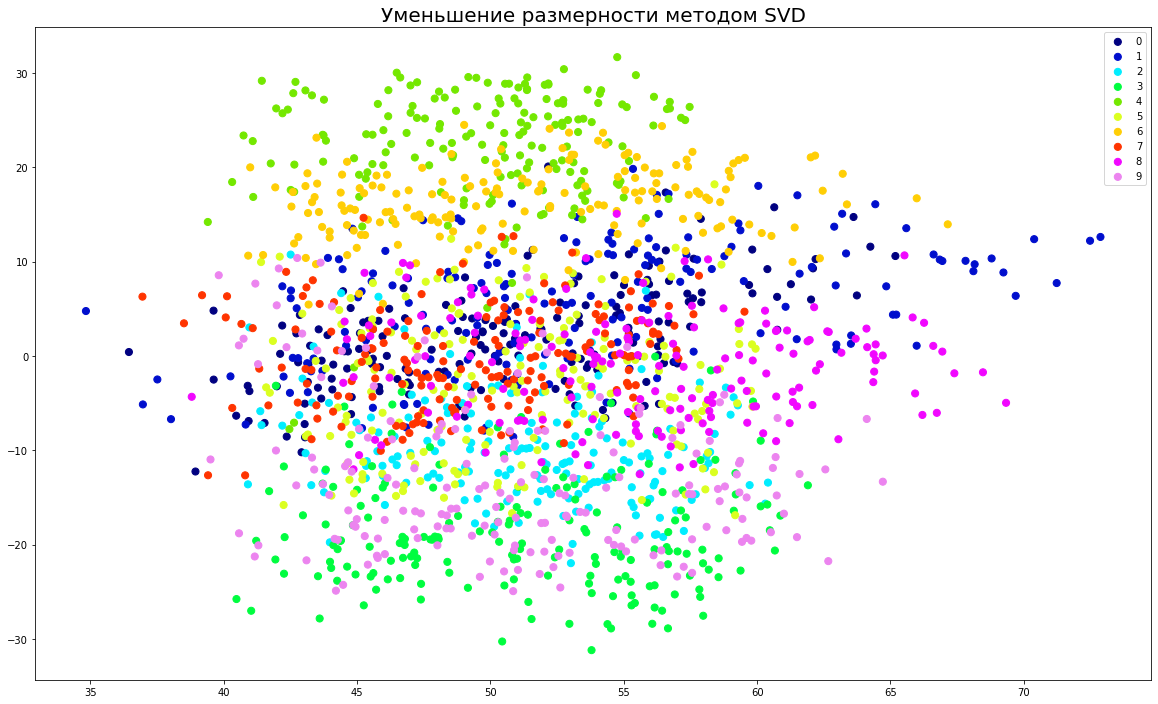

In [56]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(10): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_svd_2[:, 0][y == d],
                X_svd_2[:, 1][y == d],
                c=[color] * len(X_svd_2[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом SVD", fontsize=20)
plt.legend();

## 8. PCA - метод главных компонент
<a href='http://setosa.io/ev/principal-component-analysis/'>Визуализация</a> выделения первой и второй главных компонент методом PCA.

<a href='https://ru.wikipedia.org/wiki/Метод_главных_компонент'> Метод PCA </a> заключается в том, чтобы найти в N-мерном пространстве такое K-мерное пространство, что проекция всех точек на него будет как можно более рассеянной (то есть иметь наибольшую дисперсию).

Оказывается, подходит пространство, сумма квадратов расстояния от которого до всех точек минимальна.

Первая компонента (ось) выбирается так, чтобы дисперсия проекции вдоль нее была максимальна:

![dispersion.jpg](dispersion.jpg)

После этого все точки проецируются вдоль первой компоненты и там таким же способом выбирается вторая компонента и так далее.

Получившиеся К компонент будут образовывать K-мерное пространство, проекция точек на которое будет иметь наибольшую дисперсию.

Оказывается, если применить TruncatedSVD к центрированным данным (среднее по каждой координате равно 0), то именно это и получится!

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# Применим PCA к нашим векторам с цифрами
X_pca_2 = pca.fit(X).transform(X)
X_pca_2

array([[ -1.25946645,  21.27488331],
       [  7.95761136, -20.768699  ],
       [  6.9919229 ,  -9.95598634],
       ...,
       [ 10.80128365,  -6.96025208],
       [ -4.87210017,  12.42395292],
       [ -0.34438968,   6.36554948]])

In [59]:
svd = TruncatedSVD(n_components=2)
# Применим SVD к нашим векторам с цифрами
X_centered_svd_2 = svd.fit_transform(X - np.mean(X, axis=0))
X_centered_svd_2

array([[ -1.25950064,  21.27492832],
       [  7.9576895 , -20.7687579 ],
       [  6.99191723,  -9.9559948 ],
       ...,
       [ 10.8011457 ,  -6.96014202],
       [ -4.87202578,  12.42392146],
       [ -0.34458825,   6.36569354]])

А если мы переведем в пространство большей степени, то смотрите, у нас все первые координаты всегда совпадают:

In [63]:
pca = PCA(n_components=4)

X_pca_4 = pca.fit(X).transform(X)
X_pca_4

array([[ -1.25946631,  21.27488322,  -9.46305519,  13.01417462],
       [  7.95761127, -20.76869894,   4.43950604, -14.89366147],
       [  6.99192284,  -9.95598614,   2.95855868, -12.28829123],
       ...,
       [ 10.80128367,  -6.96025218,   5.59955461,  -7.22773093],
       [ -4.87209986,  12.4239532 , -10.17086731,  -6.66887336],
       [ -0.34438964,   6.36554922,  10.77370855,  -7.7262127 ]])

Это и логично: k-я координата - это просто длины проекции на k-ю компоненту.

Давайте визуализируем две первые компоненты:

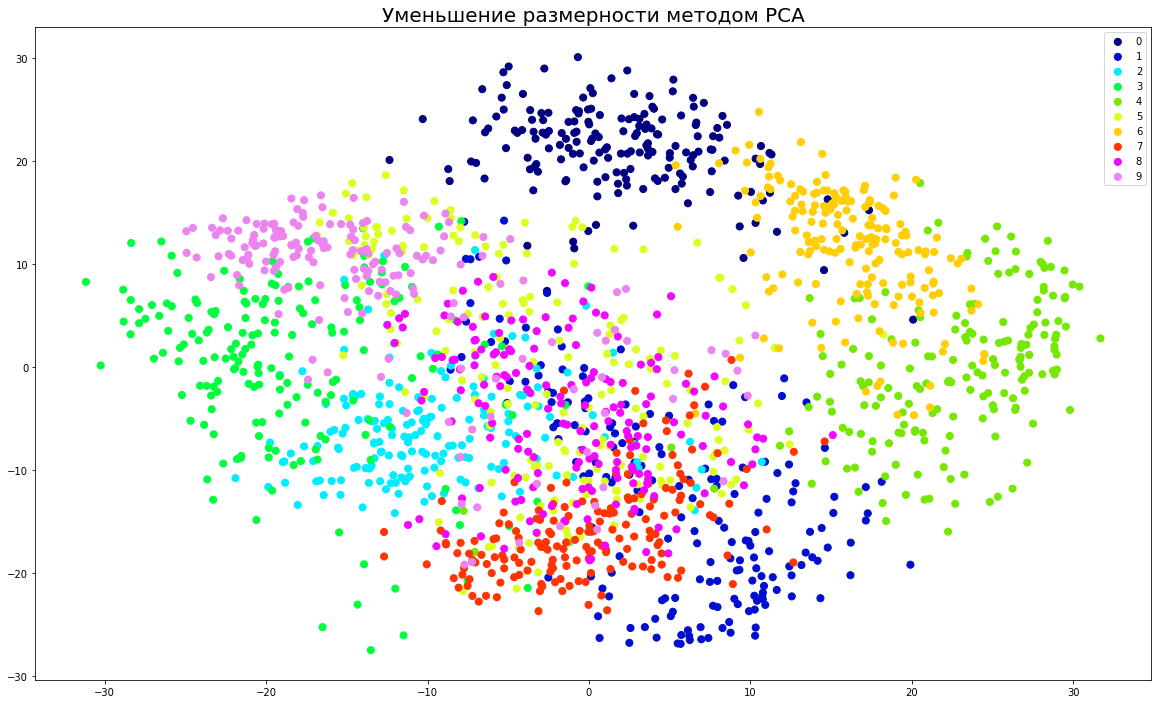

In [64]:
plt.figure(figsize=(20, 12))
for d in range(10): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_pca_2[:, 0][y == d],
                X_pca_2[:, 1][y == d],
                c=[color] * len(X_pca_2[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом PCA", fontsize=20)
plt.legend();

Как видим, получается лучше картинка, чем в SVD.

**Обязательное задание 8**: попробуйте визуализировать третью и четвертую компоненты. Какие пары цветов стало проще отделить? Какие цвета стало сложнее отделить?

**Ответ:** Практически все компоненты стало сложнее отделить

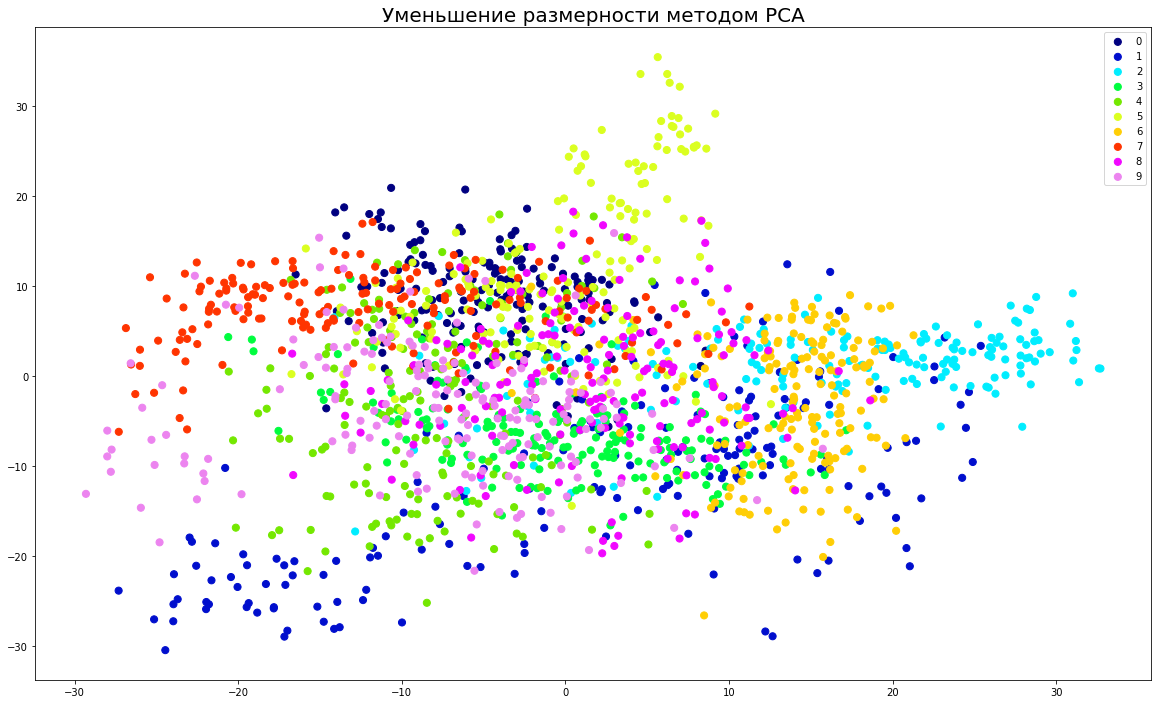

In [65]:
plt.figure(figsize=(20, 12))
for d in range(10): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_pca_4[:, 2][y == d],
                X_pca_4[:, 3][y == d],
                c=[color] * len(X_pca_2[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом PCA", fontsize=20)
plt.legend();

В каком-то смысле PCA - это лучший линейный способ уменьшить размерность пространства.

**Плюсы PCA:**
* считается относительно быстро
* детерминированность
* любая размерность
* полученную модель уменьшения размерности можно применять и к новым точкам (нужно просто спроецировать ее на выделенное K-мерное пространство)
* визуализация при K = 2 - это честная проекция на какую-то плоскость, легкая интерпретируемость результатов
* при увеличении размерности старые координаты не меняются
* отлично подходит для отбора признаков

**Минусы PCA:**
* алгоритм слишком простой - он линейный
* некоторы непохожие точки могут спроецироваться в одну и ту же при K = 2

Мы видим, что классы одинаковых цифр не до конца отделились друг от друга, и в 2-мерном пространстве эту проблему можно решить только если использовать какой-нибудь нелинейный алгоритм.

## 9. t-SNE

<a href='https://distill.pub/2016/misread-tsne/'>Визуализация</a> метода уменьшения размерности t-SNE.

Это гораздо более сложный нелинейный <a href='https://habr.com/post/267041/'> алгоритм</a>. Он очень крут для визуализации данных, и работает только с переводом в 2D и 3D.

Внутри там происходит что-то физическое - элементы будто разлетаются, причем чем дальше они друг от друга, тем сильнее они друг друга оттакливают.

**Плюсы t-SNE**
* отлично визуализирует (2D, 3D) данные
* физически разносит разные точки дальше друг от друга
* сильно разные точки не могут в конце оказаться рядом

**Недостатки t-SNE**
* недетерминированность, результат меняется при каждом запуске
* координаты ничего не значат сами по себе
* нельзя легко добавить новые данные
* долго работает
* уменьшает только до 2 и 3 размерности


Давайте запустим на 400 итерациях (у меня работает секунд 20, если у вас долго не работает, то уменьшите число итераций):

/home/fedor/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/fedor/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


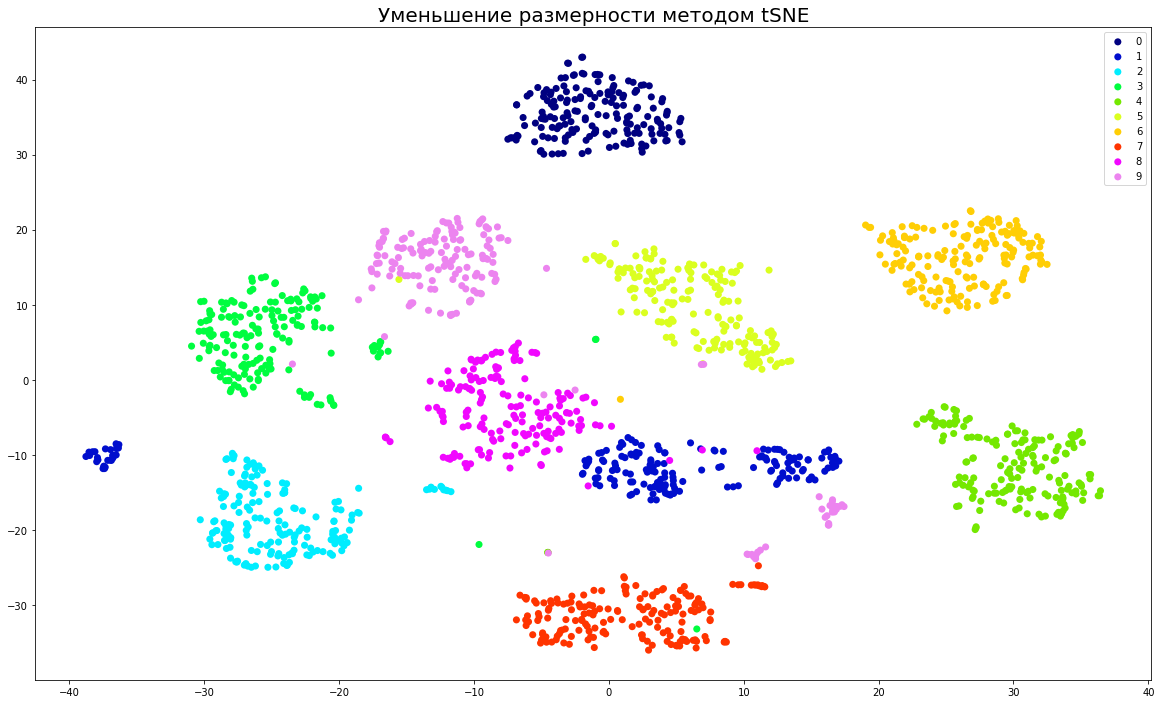

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=400)

X_tsne_2 = tsne.fit_transform(X)
plt.figure(figsize=(20, 12))
for d in range(10):
    norm = Normalize(vmin=0, vmax=10)
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_tsne_2[:, 0][y == d],
                X_tsne_2[:, 1][y == d],
                c=[color] * len(X_tsne_2[:, 0][y == d]), label=d, edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом tSNE", fontsize=20)
plt.legend()

Заметьте, что мы никак не использовали метки классов! Но они отделились фантастически!

# 10. Применение уменьшения размерности для классификации

Несмотря на то, что мы выкинули очень много данных, кажется, что во вложении tSNE решить задачу классификации стало только проще.

А вот PCA при вложении теряет много информации, и качество должно ухудшиться (зато работают быстрее).

Давайте проверим: запустим классификацию на обычном датасете и на сжатых с помощью PCA и tSNE.

In [67]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

# будем применять, например, логистическую регрессию
print('accuracy for raw data is {}'.format(cross_val_score(LogisticRegression(),
                                                           X, y,
                                                           scoring='accuracy').mean()))
print('accuracy for data transormed by SVD-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_svd_2, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by PCA-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                            X_pca_2, y,
                                                                            scoring='accuracy').mean()))
print('accuracy for data transormed by tSNE-2D is {}'.format(cross_val_score(LogisticRegression(),
                                                                             X_tsne_2, y,
                                                                             scoring='accuracy').mean()))

accuracy for raw data is 0.9137650882079852
accuracy for data transormed by SVD-2D is 0.4012318167749923
accuracy for data transormed by PCA-2D is 0.585943980191891
accuracy for data transormed by tSNE-2D is 0.8931631073970907


Мы видим, что сжатый с помощью tSNE датасет все-таки проигрывает в качестве классификации обычному, но несильно. Часто уменьшение размерности даже позволяет улучшить результат.

А вот PCA сильно проигрывает tSNE. Однако это потому, что мы снизили размерность аж до двух. Давайте возьмем побольше размерность признаков.

SVD проигрывает PCA еще сильнее.

**Обязательное задание 9** :
Переберите размерность сжатия датасета с помощью PCA и посчитайте для каждой из них качество классификации. Сколько признаков достаточно оставить, чтобы качество отличалось несильно?

**Ответ:** Начиная с $n\_samples = 9$  $accuracy = 0.895$

In [69]:
scores = []
for n in range(1, 20):
    X_pca = PCA(n_components= n).fit_transform(X)
    scores.append(cross_val_score(LogisticRegression(), X_pca, y, scoring='accuracy').mean())

Text(0, 0.5, 'accuracy')

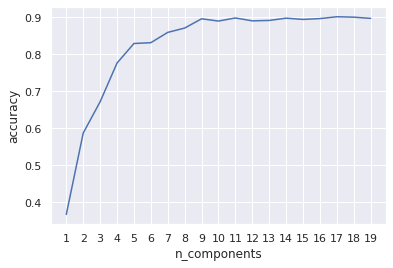

In [77]:
import seaborn as sns
sns.set_theme()
plt.plot(np.arange(1, 20, dtype=np.int64), scores)
plt.xticks(np.arange(1, 20, dtype=int))
plt.xlabel('n_components')
plt.ylabel('accuracy')

In [81]:
print(scores[8])

0.8959517177344475


Интересно еще посмотреть на ошибки нашей классификации:

In [82]:
model = LogisticRegression()
X_tsne_2_train, X_tsne_2_test, y_tsne_2_train, y_tsne_2_test = train_test_split(X_tsne_2, y, random_state=42)
model.fit(X_tsne_2_train, y_tsne_2_train)
y_pred = model.predict(X_tsne_2_test)
errors = (y_pred != y_tsne_2_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
NUMBER_DIGITS = 10
sns.set_theme(style="ticks")
plt.figure(figsize=(20, 12))
digits = X_test[errors][:NUMBER_DIGITS]
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(digit.reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

In [84]:
# Предсказали:
y_pred[errors][:len(digits)]

array([2, 1, 8, 3, 8, 1, 8, 1, 1, 1])

In [85]:
# А на самом деле:
y_test[errors][:len(digits)]

array([1, 9, 3, 1, 9, 8, 3, 9, 2, 8])

В некоторых из этих примеров и люди могут ошибиться :)